# 导入基本的python库
注：使用torchvision是为了导入FashionMnist库，并没有用于其他用处

In [1]:
import numpy as np
from torchvision import datasets
from matplotlib_inline import backend_inline
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from IPython import display
import time
import os
import math
import pandas as pd

# 导入数据集
- 导入数据集
    - Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。60000/10000的训练测试数据划分，28x28的灰度图片。标注编号从0-9分别代表了T-shirt/top（T恤）、Trouser（裤子）、Pullover（套衫）、Dress（裙子）、Coat（外套）、Sandal（凉鞋）、Shirt（汗衫）、Sneaker（运动鞋）、Bag（包）、Ankle boot（踝靴）
- 数据处理
    - 将图片转化为array并且归一化，并将其展平方便后续进入模型输入

In [2]:
train = datasets.FashionMNIST(root="/mnt/ly/miniconda3/envs/shiwei/data/", train=True, download=False)
test = datasets.FashionMNIST(root="/mnt/ly/miniconda3/envs/shiwei/data/", train=False, download=False)

train_image = []
train_label = []
test_image = []
test_label = []

for img, label in train:
    image_np = np.array(img, dtype=np.float32) / 255.0
    image_np = image_np.reshape(784)
    train_image.append(image_np)
    train_label.append(label)

for img, label in test:
    image_np = np.array(img, dtype=np.float32) / 255.0
    image_np = image_np.reshape(784)
    test_image.append(image_np)
    test_label.append(label)

In [3]:
train_image = np.array(train_image)
train_label = np.array(train_label)
test_image = np.array(test_image)
test_label = np.array(test_label)

print(train_image.shape)
print(test_image.shape)

(60000, 784)
(10000, 784)


# 定义各类函数

## 激活函数及相关
定义了Relu函数、Relu函数的反向传播以及Softmax函数

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    softmax_x = exp_x / exp_x.sum(axis=1, keepdims=True)
    return softmax_x

## 损失函数
定义了交叉熵函数

In [5]:
def cross_entropy(Y, Y_hat, params, l2_reg=0.0):
    m = Y.shape[0]
    log_likelihood = -np.log(Y_hat[range(m), Y])
    loss = np.sum(log_likelihood) / m
    l2_cost = 0.5 * l2_reg * sum(np.sum(W**2) for W in [params['W1'], params['W2']])
    return loss + l2_cost

## 梯度下降
定义了SGD优化器，并且配置了学习率下降（指数衰减）

In [6]:
class SGD:
    def __init__(self, params, grads, learning_rate=0.01, decay_rate = 0.001):
        self.params = params
        self.initial_lr = learning_rate
        self.lr = learning_rate
        self.grads = grads
        self.decay_rate = decay_rate
        self.step_num = 0
        self.lrs = []# 记录学习率

    def step(self, l2_reg=0.0):
        for key in self.params.keys():
            if 'W' in key:
                dW = self.grads['d' + key] + l2_reg * self.params[key]
                self.params[key] -= self.lr * dW
            else:
                self.params[key] -= self.lr * self.grads['d' + key]
        self.update_learning_rate()

    def update_learning_rate(self):# 指数衰减
        self.step_num += 1
        self.lr = self.initial_lr * math.exp(-self.decay_rate * self.step_num)      
        self.lrs.append(self.lr)  # 记录当前学习率   

# 定义三层神经网络模型
- 针对参数和梯度进行了初始化，梯度初始化为0，参数使用He初始化方法
- 定义了正向过程和反向传播

In [7]:
class ThreeLayer:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=10, init_params=None):
        # 参数和梯度初始化
        if init_params is None:
            self.params = {
                'W1': np.random.randn(input_size, hidden_size1) / np.sqrt(input_size / 2),
                'b1': np.zeros((1, hidden_size1)),
                'W2': np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1 / 2),
                'b2': np.zeros((1, hidden_size2)),
                'W3': np.random.randn(hidden_size2, output_size) / np.sqrt(hidden_size2 / 2),
                'b3': np.zeros((1, output_size))
            }
        else:
            self.params = init_params
        
        self.grads = {
            'dW1': np.zeros_like(self.params['W1']),
            'db1': np.zeros_like(self.params['b1']),
            'dW2': np.zeros_like(self.params['W2']),
            'db2': np.zeros_like(self.params['b2']),
            'dW3': np.zeros_like(self.params['W3']),
            'db3': np.zeros_like(self.params['b3'])
        }

    # 定义前向过程
    def forward(self, X):
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = relu(Z2)
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        A3 = softmax(Z3)
        self.forward_cache = (Z1, A1, Z2, A2, Z3, A3)
        return A3

    # 定义反向传播
    def backward(self, X, Y):
        Z1, A1, Z2, A2, Z3, A3 = self.forward_cache
        m = Y.shape[0]

        dZ3 = A3
        dZ3[range(m), Y] -= 1
        dZ3 /= m
        dW3 = A2.T.dot(dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)
        dA2 = dZ3.dot(self.params['W3'].T)
        dZ2 = relu_backward(dA2, Z2)
        
        dW2 = A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2.dot(self.params['W2'].T)
        dZ1 = relu_backward(dA1, Z1)
        
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        
        self.grads['dW1'], self.grads['db1'] = dW1, db1
        self.grads['dW2'], self.grads['db2'] = dW2, db2
        self.grads['dW3'], self.grads['db3'] = dW3, db3
        
    def update_params(self, optimizer, l2_reg):
        optimizer.step(l2_reg)


**定义准确率评估函数与绘图函数**
- 包含计时函数、保存参数的配置

In [8]:
# 计算预测正确的数量
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: 
        y_hat = np.argmax(y_hat, axis=1) 
    cmp = y_hat == y
    return float(sum(cmp))      

# 计算在指定数据集上模型的精度
def evaluate_accuracy(net, X_test, y_test):
    metric = Accumulator(2) 
    metric.add(accuracy(net.forward(X_test), y_test), len(X_test)) 
    return metric[0] / metric[1] 

# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a,b in zip(self.data,args)] 
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

# 定义绘图坐标轴
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# 定义运行时间函数
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

# 绘图函数，记录loss和训练集/测试集准确率
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 绘图函数，绘制学习率
def plot_learning_rate(sgd):
    plt.plot(sgd.lrs)
    plt.xlabel('Step Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Decay Over Time')
    plt.grid(True) 
    plt.show()

# 保存模型参数
def save_model_weights(params, folder='weights', filename='model_weights.npy'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_path = os.path.join(folder, filename)
    np.save(file_path, params)

# 训练模型

**定义训练函数**

In [18]:
# 训练函数
def train(X_train, y_train, X_test, y_test, model, optimizer, batch_size, epoch, l2_reg=0.0, save_threshold = 0.0):    
    animator = Animator(xlabel='epoch', xlim=[1, epoch],
                            legend=['train loss', 'train acc', 'test acc'], ylim=[0,1])
    timer= Timer()
    
    '''训练过程'''
    for epoch in range(epoch):
        X, Y = shuffle(X_train, y_train, random_state=42)# 随机打乱读取X，y
        metric = Accumulator(3)
        
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i: i + batch_size]
            Y_batch = Y[i: i + batch_size]
            timer.start()
            y_hat= model.forward(X_batch)
            accu_count = accuracy(y_hat, Y_batch)
            loss = cross_entropy(Y_batch, y_hat, model.params, l2_reg)
            model.backward(X_batch, Y_batch)
            model.update_params(optimizer, l2_reg)
            metric.add(loss * batch_size, accu_count, batch_size)
            timer.stop()
        train_metrics = (metric[0] / metric[2], metric[1] / metric[2])

        test_acc = evaluate_accuracy(model, X_test, y_test)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
        if test_acc > save_threshold:
            save_threshold = test_acc
            save_model_weights(model.params, folder='weights', filename=f'best_model_weights_{epoch+1}_{save_threshold:.4f}.npy')
            print(f"Saved better model with acc: {save_threshold:.4f}")
            
    print(f'loss {metric[0] / metric[2]:.3f}, accuracy_train {metric[1] / metric[2]:.3f}, accuracy_test {test_acc:.3f}')
    print(f'{metric[2] * epoch / timer.sum():.1f} examples/sec, average run time {timer.sum() / epoch:.3f} sec every epoch')

## 开始训练

loss 0.183, accuracy_train 0.952, accuracy_test 0.893
27170.0 examples/sec, average run time 2.209 sec every epoch


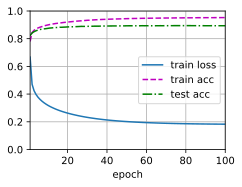

In [10]:
model = ThreeLayer(input_size=784, hidden_size1=256, hidden_size2=128, output_size=10, init_params = None)
sgd = SGD(params = model.params, grads = model.grads, learning_rate = 0.1, decay_rate = 1e-4)
train(train_image, train_label, test_image, test_label, model, sgd, batch_size = 128, epoch = 100, l2_reg=1e-4, save_threshold = 0.85)

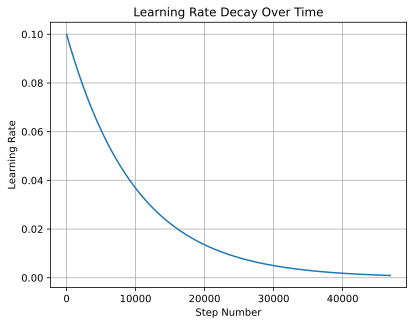

In [11]:
plot_learning_rate(sgd)

## 训练过程/调参记录

1. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 0.001, batch_size =256, l2_reg = 0.001, epoch = 100
    - loss 0.685, accuracy_train 0.874, accuracy_test 0.858
    - 仅仅**前10epoch左右，loss明显降了下来**。**后续开始loss降不下来，训练集测试集准确率都上不去**，卡在0.85左右
    - 最优测试集准确率是29epoch，准确率0.8582
    - 更新尝试：
        - **学习率降低太快**，更改decay_rate
        - 尝试减少L2正则化系数，特别是如果**模型显示出无法有效降低训练误差的迹象**

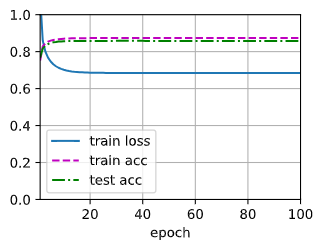


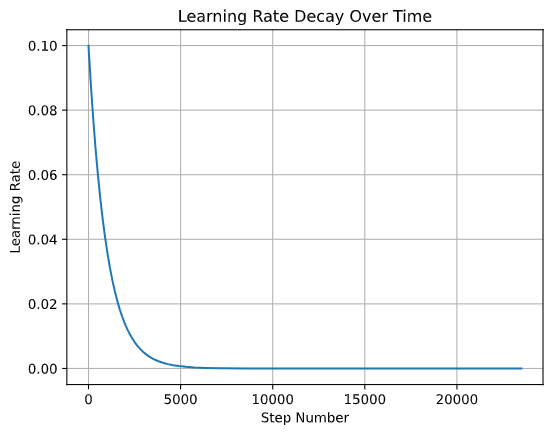

2. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 1e-4, batch_size =256, l2_reg = 1e-4, epoch = 100
    - loss 0.179, accuracy_train 0.952, accuracy_test 0.894
    - 比上一次调参结果更好，但是**过拟合严重**
    - 最优测试集准确率是93epoch，准确率0.8937
    - 最新尝试：
        - 将L2正则化系数恢复为0.001，**降低过拟合的程度**

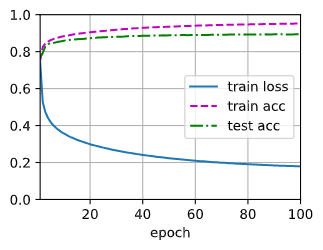

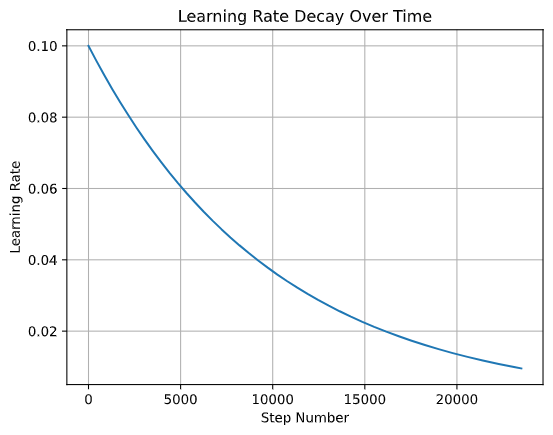

3. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 1e-4, batch_size =256, l2_reg = 1e-3, epoch = 100
    - loss 0.317, accuracy_train 0.934, accuracy_test 0.891
    - 跟上次调参效果相差不大，**过拟合依旧严重**
    - 最优测试集准确率是97epoch，准确率0.8924
    - 最新尝试：
        - **改变模型框架**：隐藏层大小(128,128)/(128,64)/(128,256)
            - hidden_size1=128, hidden_size2=128, lr=0.1, decay_rate = 1e-4, batch_size =256, l2_reg = 1e-3, epoch = 100
                - loss 0.313, accuracy_train 0.925, accuracy_test 0.888
            - hidden_size1=128, hidden_size2=64, lr=0.1, decay_rate = 1e-4, batch_size =256, l2_reg = 1e-3, epoch = 100
                - loss 0.297, accuracy_train 0.927, accuracy_test 0.892
            - hidden_size1=128, hidden_size2=256, lr=0.1, decay_rate = 1e-4, batch_size =256, l2_reg = 1e-3, epoch = 100
                - loss 0.328, accuracy_train 0.928, accuracy_test 0.889
            - 以上结果相差并不大，**更改模型结构收益不多**
        - **降低batch_size**为128

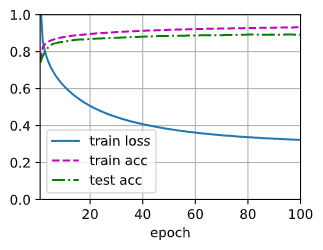

4. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 1e-4, batch_size =128, l2_reg = 1e-3, epoch = 100
    - loss 0.309, accuracy_train 0.934, accuracy_test 0.893，最优测试集准确率是100epoch，准确率0.8929
    - **学习率下降依旧太快**，感觉依旧有增长空间，尝试**继续降低衰减率**

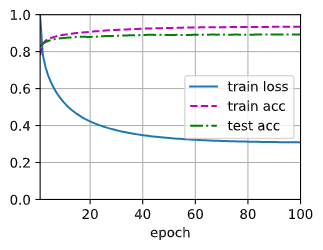

5. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 1e-5, batch_size =128, l2_reg = 1e-3, epoch = 100
    - loss 0.266, accuracy_train 0.945, accuracy_test 0.887，最优测试集准确率是93epoch，准确率0.8880
    - **与最好的第二次调参结果做综合，在第二次基础上减少batch_size**

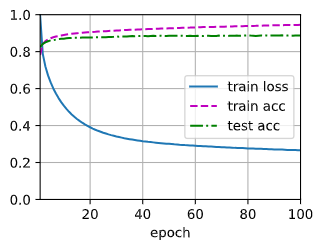

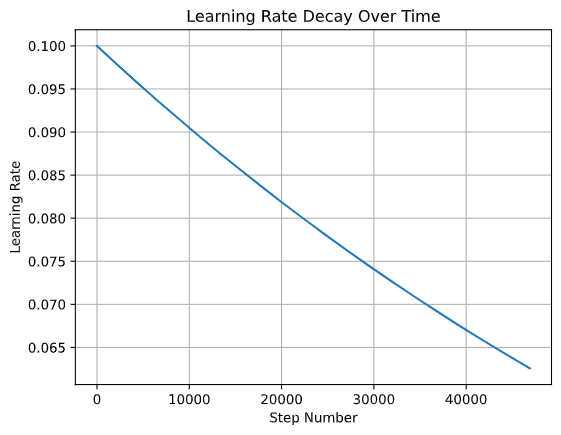

6. hidden_size1=256, hidden_size2=128, lr=0.1, decay_rate = 1e-4, batch_size =128, l2_reg = 1e-4, epoch = 100
    - loss 0.183, accuracy_train 0.952, accuracy_test 0.893
    - **最优测试集准确率是72epoch，准确率0.8982**目前是最好的
    - 如**上方开始训练**所示

**参数可视化**

In [12]:
def visualize_weights(weights, img_shape=(28, 28), figsize=(8, 8)):
    grid_size = int(np.ceil(np.sqrt(weights.shape[1])))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    weight_min = weights.min()
    weight_max = weights.max()

    for i, ax in enumerate(axes.flat):
        if i < weights.shape[1]:
            img = weights[:, i].reshape(img_shape)
            img = (img - weight_min) / (weight_max - weight_min)
            ax.imshow(img, cmap='gray', interpolation='nearest')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

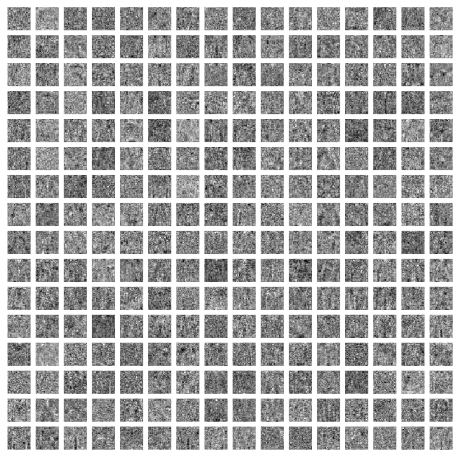

In [13]:
# 可视化W1参数
visualize_weights(model.params['W1'])

第一层的参数主要捕捉的是周围的边缘信息，可以在一些图片中隐约看到t-shirt&dress的轮廓。

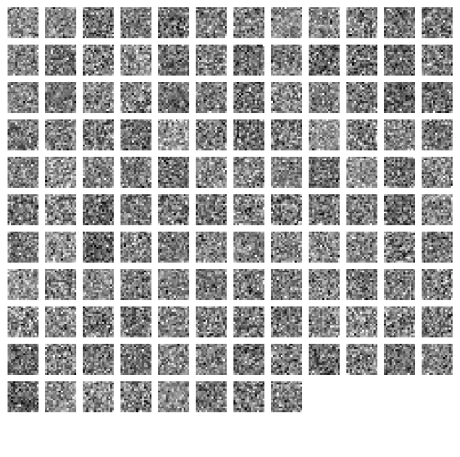

In [14]:
# 可视化W2参数
visualize_weights(model.params['W2'], img_shape=(16, 16))

第二层的参数可视化愈加模糊，无法完全确定图像所要提取的重要特征，可能是因为层数过低导致的，随着层数加深，最下面的几层参数可视化应该会越明显。

**使用已保存参数测试模型**

In [15]:
def load_model_weights(filename):
    return np.load(filename, allow_pickle=True).item()

# 读取100个测试数据进行结果评析
def evaluate_samples(model, X_test, y_test, num_samples=100):
    predictions = []
    for i in range(num_samples):
        y_hat = model.forward(X_test[i].reshape(1, -1))
        predicted_label = np.argmax(y_hat, axis=1)
        predictions.append(predicted_label[0])
    data = {'Y_hat': predictions, 'y_test': y_test[:num_samples]}
    df = pd.DataFrame(data)
    return df

In [17]:
saved_params = load_model_weights("/home/ly/weights/best_model_weights_72_0.8982.npy")
model = ThreeLayer(input_size=784, hidden_size1=256, hidden_size2=128, output_size=10, init_params=saved_params)
print(f"最优参数对应模型的测试集正确率为：{evaluate_accuracy(model, test_image, test_label)}")

result_df = evaluate_samples(model, test_image, test_label)
count = result_df["Y_hat"].eq(result_df["y_test"]).sum()
print(f"在前100个测试数据中，正确分类{count}个，比例{count/100:.0%}")
result_df.head()

最优参数对应模型的测试集正确率为：0.8982
在前100个测试数据中，正确分类87个，比例87%


,Y_hat,y_test
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
